In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, probplot
import pylab
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_features = pd.read_csv('mice_behavior_capstone/process_data/results/all_the_data.csv')

#Strings to not be considered
arms= ['CL', 'CR', 'OT', 'OB', 'M', 'F1', 'F2', 'F3', 'F4', 'right', 'left', 'middle', 'top', 
       'bottom', 'count', '_num_', 'median']

In [3]:
#Considers only these features
cols_main= [col for col in df_features.columns if not any(arm in col for arm in arms)]
cols_main_final = [e for e in cols_main if e not in ('Unnamed: 0', 'inner_directory', 'mouse_details_date', 'mouse_details_mouseID',
                                              'mouse_details_time',)]

In [4]:
df_features_final= df_features.loc[:, cols_main_final].dropna()

#Also, remove outliers

In [5]:
final_features= [col for col in df_features_final.columns if col not in ('mouse_details_sex', 'mouse_details_strain')]

In [6]:
def significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal = [] #Boolean
    normality_p = [] #Tuple of normality test results
    stats_test_p = [] #P values
    significance = [] #Boolean, for significance
    
    df_features_final= df_features
    final_features= features

    for feature in final_features:

        strain1= df_features_final.loc[df_features_final['mouse_details_strain']=='BW', feature] 
        strain2= df_features_final.loc[df_features_final['mouse_details_strain']=='PO', feature]

        #Do a Normality test and store p value
        norm1 = shapiro(strain1)[1]
        norm2 = shapiro(strain2)[1]
        
        #If not normal, do a log transformation
        if max(norm1, norm2) < alpha_normal: 
            strain1= np.log(strain1)
            strain2= np.log(strain2)
                       
            norm1 = shapiro(strain1)[1]
            norm2 = shapiro(strain2)[1]
        
        normality_p.append((norm1, norm2))
        
        #Conduct a t-test if both distributions are probably sampled from a N(mu, sigma)
        if max(norm1, norm2) > alpha_normal:        
            normal.append(True)

            #Do a t-test(or Anova)
            p = ttest_ind(strain1, strain2)[1]
            stats_test_p.append(p)

            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)
        
        #Else, perform a non-parametric test - ideally, not performed if outliers are removed
        else:
            normal.append(False)
            p = mannwhitneyu(strain1, strain2)[1]
            stats_test_p.append(p)
            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)

    return normal, normality_p, significance, stats_test_p

In [7]:
normal, normality_p, significance, stats_test_p= significance(df_features_final, final_features)

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/srinidhi/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3860: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


## Results

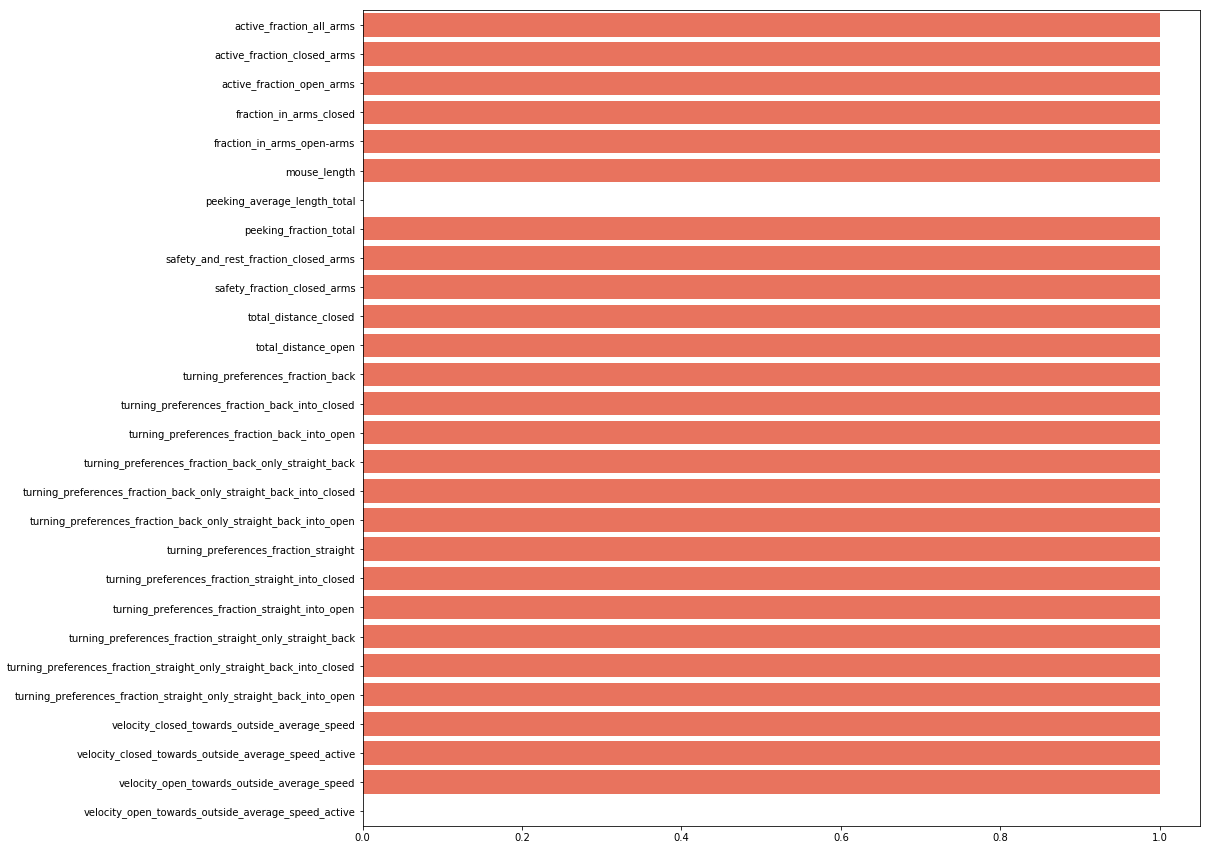

In [8]:
plt.figure(figsize=(15, 15))
sns.barplot(x= normal, y= final_features, color='tomato')
plt.show()

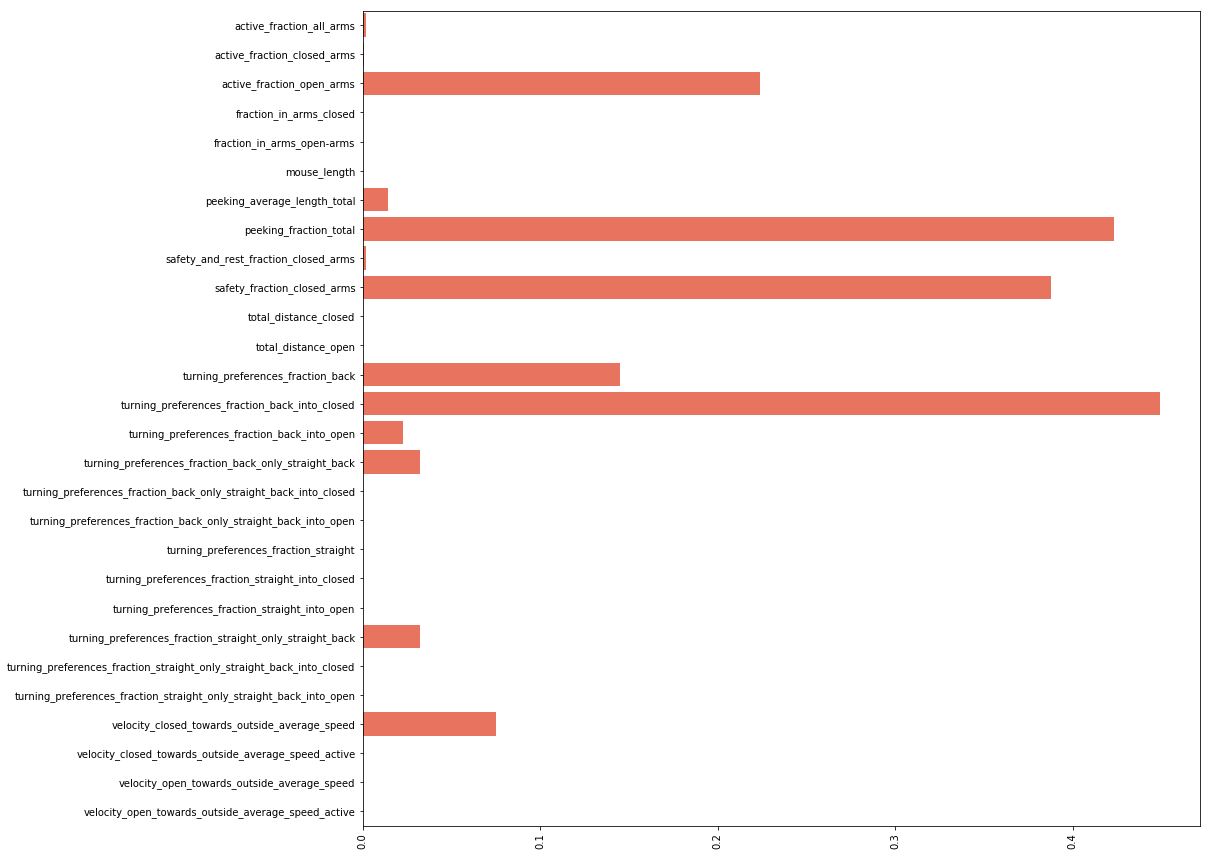

In [9]:
plt.figure(figsize=(15, 15))
sns.barplot(x=stats_test_p, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.show()

## Example where Log transformation works

In [24]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total'])[1])
print(shapiro(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total']))[1])

2.307562454006984e-06
0.1192852109670639


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


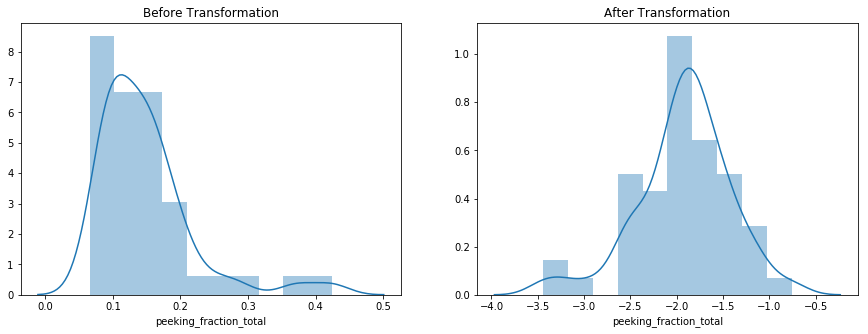

In [22]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Before Transformation")
sns.distplot(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total'], bins=10)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Transformation")
sns.distplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'peeking_fraction_total']), bins=10)
plt.show()

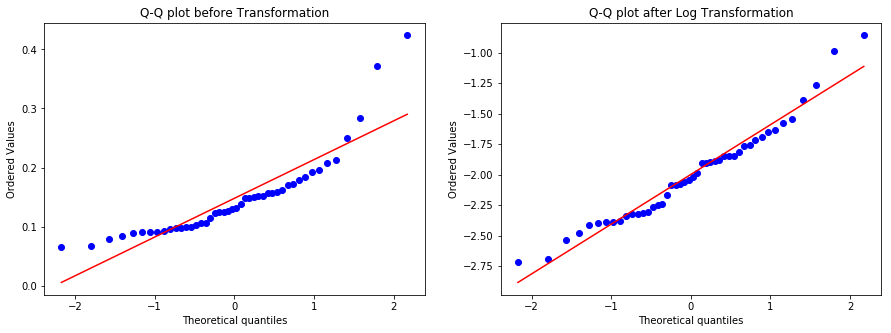

In [20]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation")

plt.subplot(1, 2, 2)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_fraction_total']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation")

plt.show()

## Negative effect of outliers 
- Log transformation won't work as Shapiro wilk test is very sensitive

In [25]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total'])[1])
print(shapiro(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total']))[1])

3.305426048427762e-07
0.0015785748837515712


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


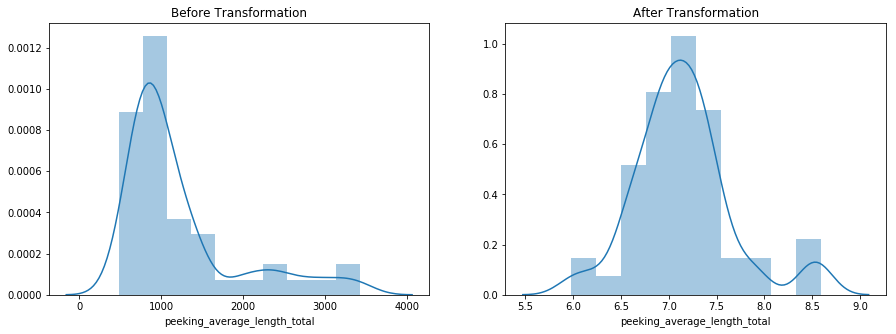

In [26]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Before Transformation")
sns.distplot(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total'], bins=10)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Transformation")
sns.distplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'peeking_average_length_total']), bins=10)
plt.show()

#The RHS mostly looks normal except those outliers around 8.5

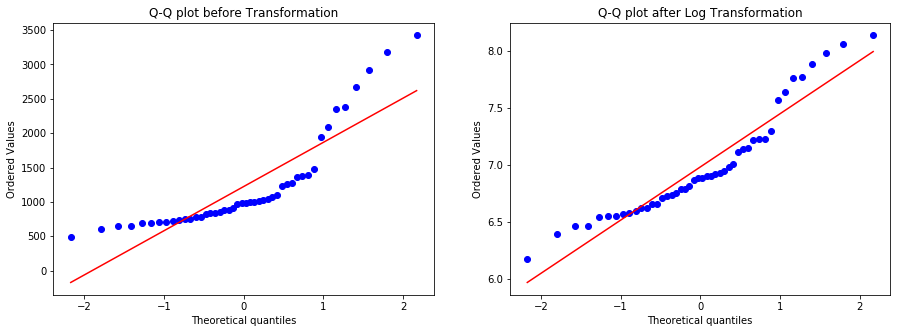

In [27]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation")

plt.subplot(1, 2, 2)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation")

plt.show()

#Outliers clearly seen!


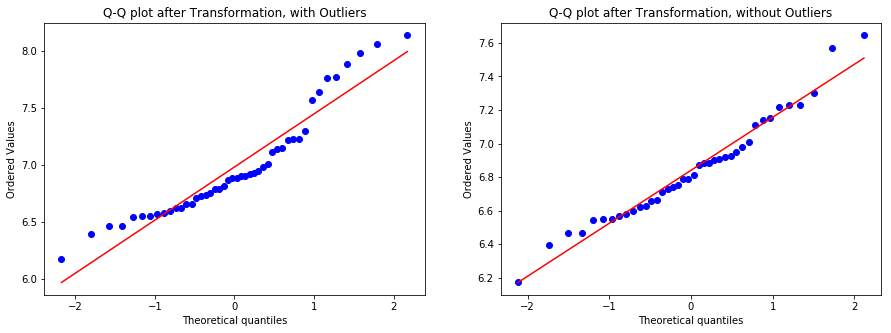

In [30]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total'])[:-6]), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [32]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total'])[1])
print(shapiro(np.log(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='BW', 'peeking_average_length_total']))[:-6]))[1])

#Outlier removal clearly helped!


3.305426048427762e-07
0.6333306431770325
